In [79]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from numba import jit

MAX_TIME = 2
EPS = 1e-7
GG = 32.174

METRICS = ['prob','rink_ctrl','best_case','expected']
TIME_PENALTY = 0.1
MAX_VEL=35.5   # maximum skater velocity in ft/sec
ALPHA = 1.3 # acceleration coefficient (not directly acceleration, but more like a speed decay)
TR = 0.189 # reaction time (based on the article Phil sent) 
MM = 0.1 # Coefficient of friction between puck and ice, I'll find the source for this
BETA_PUCK = 0.1322 # Puck air drag coefficient (actuall it's the coefficient divided by the mass so beta = k/m if k is the drag coefficient)
BETA_CTRL = 2.5 # pitch control coefficient used as beta in ice_ctrl_xyt and teamwise_ice_ctrl_xyt, taken from the Spearman paper
X_DECAY = 2000 #value used as decay_x
Y_DECAY = 500 #value used as decay_y
GOALIE_DIST = 8 # maximum reasonable distance for goalie to go away from goal
GLX = 11 # Goalie X coord
GLY = 42.5  # Goalie Y coord
STICK = 5 # Stick length 
TARGET_RADIUS = 27.5

@jit(nopython  = True)
def inside_boards(x: np.ndarray,y: np.ndarray, t:np.ndarray,
                  target_radius: float = TARGET_RADIUS):
    radius = (x<28) * ((y>57)*((x-28)**2 + (y-57)**2)**0.5 + (y<28)*((x-28)**2 + (28-y)**2)**0.5)
    ix = (radius<=target_radius) * (0<x) * (x<100) * (0<y) * (y<85)
    return x[ix],y[ix],t[ix]

class tracks():
    def __init__(self,
                x: np.ndarray, # x locations of players (array or list of floats) 
                y: np.ndarray, # y locations of players (array or list of floats)
                vx: np.ndarray, # x velocity of players (array or list of floats)
                vy: np.ndarray, # y velocity of players (array or list of floats)
                goalie: int, # column number for goalie
                puck: int, # column number for which player has the puck
                off: np.ndarray, # array or list of integers +1 for offence, -1 for defence (or true and false)
                vp: float = 55,
                phi_res: float = 0.01,
                t_res: float = 0.01,
                # metric: str = 'expected'
                ):
        assert len(set([len(x),len(y),len(vx),len(vy),len(off)]))<=2
        # if not metric in METRICS:
            # raise ValueError('Metric choice is not in recognized metric list, please choose another metric')
        # self.metric = metric
        self.xp = x[puck]
        self.yp = y[puck]
        self.puck = puck
        self.phi_res = phi_res
        self.off = np.where(off==1,1,-1)
        self.t_res = t_res
        self.vp = vp
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.goalie = goalie
        # self.tracks = pd.DataFrame({'x':x,'y':y,'vx':vx,'vy':vy,'goalie':goalie,'off':off})
        self.player_motion()
        self.grid = np.concatenate([self.one_pass(self, phi)() for phi in np.arange(-np.pi,np.pi+EPS, phi_res)], axis = 0)

    def player_motion(self, alpha: float = ALPHA, t_r: float = TR, vmax: float = MAX_VEL):
        t = np.arange(self.t_res,MAX_TIME, self.t_res).reshape(-1,1)
        # x = self.x.reshape(-1,1)
        # vx = self.vx.reshape(-1,1)
        # y = self.y.reshape(-1,1)
        # vy = self.vy.reshape(-1,1)

        self.c_x = np.where(t<t_r, self.x + self.vx * t, self.x + t_r * self.vx + self.vx * (1-np.exp(-alpha * (t-t_r))/alpha))
        self.c_y = np.where(t<t_r, self.y + self.vy * t, self.y + t_r * self.vy + self.vy * (1-np.exp(-alpha * (t-t_r))/alpha))
        self.r = np.where(t<t_r,0,vmax * (t -t_r - (1-np.exp(-alpha * (t-t_r)))/alpha)) 


    class one_pass():
        def __init__(self, outer_self: 'tracks', phi: float):
            self.t_res = outer_self.t_res
            self.phi = phi
            self.x0 = outer_self.xp
            self.y0 = outer_self.yp
            self.vp = outer_self.vp
            self.x,self.y,self.t = self.make_grid()
            self.outside_creese = (self.x-GLX)**2 + (self.y-GLY)**2 > GOALIE_DIST**2
            self.get_metric(outer_self)#, outer_self.metric)
        
        def make_grid(self):
            t = np.arange(self.t_res,MAX_TIME,self.t_res)
            x, y = self.puck_motion_model(t)
            return inside_boards(x,y,t)
            

        def puck_motion_model(self,t: np.ndarray,
                                    mu:float = MM, 
                                    beta: float = BETA_PUCK, 
                                    g: float = GG):
                vx = self.vp*np.sin(self.phi)
                vy = -self.vp*np.cos(self.phi)
                
                x =  self.x0 + (vx + mu*g * vx/self.vp/beta) * (1 - np.exp(-beta * t))/beta - (mu*g * t * vx/self.vp)/beta
                y = self.y0 + (vy + mu*g * vy/self.vp/beta) * (1 - np.exp(-beta * t))/beta - (mu*g * t * vy/self.vp)/beta
                
                return x, y
        
        def score_prob(self, decay_x = X_DECAY, decay_y = Y_DECAY):
            # Scoring Probability function 
            x = self.x
            y = self.y
            self.score = (np.abs((x-11)/((42.5-y)**2+(11-x)**2)**0.5)+1)/np.where(x<11,8,4)*np.exp(-((11-x)**2/decay_x +(42.5-y)**2/decay_y))


        def dist_to_xyt(self,outer_self: 'tracks'):
                # If time is smaller than reaction time, skater keeps going at initial speed
            ln = len(self.t)
            tx = self.x.reshape(-1,1)
            ty = self.y.reshape(-1,1)

            remaining_dist = ((tx-outer_self.c_x[:ln,:])**2 + (ty-outer_self.c_y[:ln,:])**2)**0.5-outer_self.r[:ln,:]
            return(np.maximum(remaining_dist,EPS))
        
                
        def get_metric(self,outer_self: 'tracks'):  #, metric: str = 'prob'):
            # dists = np.array([self.dist_to_xyt(x0,y0,vx,vy) for x0,y0,vx,vy in zip(outer_self.x, outer_self.y, outer_self.vx, outer_self.vy)]).T
            dists = self.dist_to_xyt(outer_self)
            dists[self.outside_creese,outer_self.goalie]  = np.maximum(dists[self.outside_creese,outer_self.goalie], ((self.x[self.outside_creese]-GLX)**2 + (self.y[self.outside_creese]-GLY)**2)**0.5 - GOALIE_DIST)
            ctrl =(dists/MAX_VEL)**(-BETA_CTRL)* outer_self.off.reshape(1,-1)
            self.all_ctrl = ctrl.sum(1)/np.abs(ctrl).sum(1)
            # if metric == 'rink_ctrl':
                # self.metric = self.all_ctrl
                # return 0
            
            dists = np.delete(dists, outer_self.puck,axis = 1)
            off_mat = np.delete(outer_self.off, outer_self.puck)
            base_probs = self.t_res * (norm.cdf(dists/STICK+1)-norm.cdf(dists/STICK-1))/TIME_PENALTY * (1 - np.exp(-self.t.reshape(-1,1)/(TR + TIME_PENALTY * off_mat.reshape(1,-1))))
            ranks = (-base_probs).argsort()
            # print(ranks.shape, base_probs.shape)
            ranked_probs = np.take_along_axis(base_probs,ranks,1)
            off_mat = off_mat[ranks]
            # print(off_mat)
            # print(np.concatenate((np.ones((1,dists.shape[1])),1-ranked_probs[:-1,:]),0).cumprod(1).shape)
            adj_probs = np.concatenate((np.ones((1,dists.shape[1])),1-ranked_probs[:-1,:]),0).cumprod(1)*ranked_probs
            # print(adj_probs.shape)
            adj_pass_off = (adj_probs*(off_mat==1)).sum(1)
            # pass_def = adj_probs[~off_mat] # Not sure we actually need this line
            missed = 1 - adj_probs.sum(1)
            missed = np.append(1,missed[:-1]).cumprod()
            pass_off = adj_pass_off * missed
            # if metric == 'prob':
            #     self.metric = pass_off.sum()  * np.ones(self.x.shape)
            # if metric == 'best_case':
            #     self.score_prob()
            #     adj_pass_value = self.score*all_ctrl*adj_pass_off
            #     self.metric = adj_pass_value.max() * np.ones(self.x.shape)

            # elif metric == 'expected':
            #     self.score_prob()
            #     loc_pass_value = self.score*all_ctrl*pass_off
            #     self.metric = loc_pass_value.sum() * np.ones(self.x.shape)
            self.prob = pass_off.sum()  * np.ones(self.x.shape)
            self.score_prob()
            adj_pass_value = self.score*self.all_ctrl*adj_pass_off
            self.best_case = adj_pass_value.max() * np.ones(self.x.shape)
            loc_pass_value = self.score*self.all_ctrl*pass_off
            self.expected = loc_pass_value.sum() * np.ones(self.x.shape)

        def __call__(self):   
            return np.stack((self.x,self.y,self.t,self.all_ctrl,self.prob,self.best_case,self.expected),1)    





In [84]:
x=200-np.array([171.4262, 155.6585, 153.7146, 150.5869, 156.3463, 179.8383, 180.8131, 186.6146, 179.9982])
y=85 - np.array([49.31514, 48.25991, 70.17542, 13.65429, 28.51970, 38.44596, 36.80571, 38.32781, 22.03946])
vx= -np.array([6.725073,  4.964445, -3.097599, 14.252625,  4.286796,  1.925091, -2.295729, -0.294258,  6.464229])
vy= - np.array([-7.1037417,  -7.9677960,  -6.4446342,   6.5618985, -10.9455216,  -4.7444208,  -4.1465373,  -0.3377985, -5.4265284])
goalie = 7
puck= 3
off=np.array([-1, -1, 1, 1, -1, 1, -1, -1, 1])
all_tracks = tracks(x,y,vx,vy,goalie,puck,off, t_res = 0.01, phi_res = 0.01) 


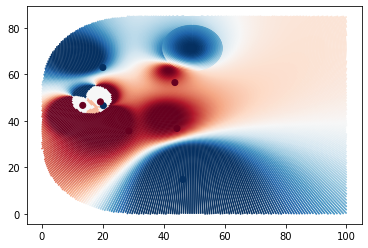

In [85]:
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d
%matplotlib inline
plt.scatter(all_tracks.grid[:,0], all_tracks.grid[:,1], c = all_tracks.grid[:,4], cmap = 'RdBu', s = .5 )
plt.scatter(all_tracks.x,all_tracks.y, c = off, cmap = 'RdBu')
plt.show()

In [61]:


f = interp2d(all_tracks.grid[:,0], all_tracks.grid[:,1], all_tracks.grid[:,3], kind="linear")
x  = np.arange(0,100,0.1)
y = np.arange(0,85,0.1)
z = f(x,y)
plt.imshow(z,
            extent = [0,100,0,85],
            origin = 'lower',
            interpolation = "bicubic", cmap = 'RdBu')

In [83]:
%timeit -n 10 all_tracks = tracks(x,y,vx,vy,goalie,puck,off, t_res = 0.01, phi_res = 0.01) 

475 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
def make_grid(t_res, phi, x0, y0):
    t = np.arange(t_res,MAX_TIME,t_res)
    x, y = puck_motion_model(t,x0,y0)
    return inside_boards(x,y,t)
    

def puck_motion_model(x0,y0,vp,t: np.ndarray,
                            phi: float,
                            mu:float = MM, 
                            beta: float = BETA_PUCK, 
                            g: float = GG):
        vx = vp*np.sin(phi)
        vy = vp*np.cos(phi)
        
        x =  self.x0 + (vx + mu*g * vx/self.vp/beta) * (1 - np.exp(-beta * t))/beta - (mu*g * t * vx/self.vp)/beta
        y = self.y0 + (vy + mu*g * vy/self.vp/beta) * (1 - np.exp(-beta * t))/beta - (mu*g * t * vy/self.vp)/beta
        
        return x, y


[71.22360684 65.3825406  53.86018895 36.69398136 13.92110069 71.22375944
 65.38999301 53.8820413  36.737287   13.9928665  71.22421685 65.41233161
 53.94754373 36.86709567 14.20798454 71.22497793 65.44950056 54.05653251
 37.08308292 14.56591715 71.22604078 65.50140697 54.20873523 37.3847089
 15.06576967 71.22740273 65.5679211  54.40377146 37.77121969 15.70629273
 71.2290604  65.64887668 54.64115371 38.24164922 16.48588535 71.23100963
 65.74407138 54.92028866 38.79482167 17.40259897 71.23324554 65.85326726
 55.2404786  39.42935438 18.45414227 71.23576257 65.97619139 55.60092324
 40.14366136 19.63788694 71.2385544  66.11253652 56.00072164 40.93595721
 20.95087424 71.24161406 66.26196186 56.43887453 41.8042616  22.38982239
 71.24493392 66.42409392 56.91428674 42.74640424 23.95113476  0.55896447
 71.24850565 66.59852745 57.42576999 43.76003024 25.63090889 71.25232035
 66.78482647 57.97204584 44.84260608 27.42494621 71.25636848 66.98252533
 58.55174888 45.99142587 29.32876257 71.26063991 67.